In [22]:
#!pip install statsmodels
#!pip install kneed
#!pip install plot-likert
#!pip install scipy
#!pip install seaborn


In [23]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import kruskal


In [24]:
data = pd.read_json("typeaware_study_data_new.json")

In [25]:
## The compilation of the data containing averages
json_data_list = []
# Loop through the JSON data
for user_id, user_data in data.items():
    for prolific_id, prolific_data in user_data.items():
        if isinstance(prolific_data, dict):
            for date, date_data in prolific_data.items():
            
                entry = {
                    "prolific_id": prolific_id,
                    "date": date,
                }

                # Extract questionnaire answers
                questionnaire = date_data.get("questionnaire", {})
                #for i in range(1, 7):
                #    entry[f"Q{i}"] = questionnaire.get(f"Q{i}", None)
                

                # Initialize lists for keyboard events data
                typing_speeds = []
                error_rates = []
                error_amounts = []
                session_counts = []
                words_per_minute = []
                session_length = []
                questionnaire_error = None

                # Initialize sleep data
                sleep_start_timestamp = None
                sleep_end_timestamp = None
                sleep_duration_minutes = None
                sleep_start_timewindow = None
                sleep_end_timewindow = None

                # Initialize end questionnaire answers
                end_questionnaire = date_data.get("endQuestionnaire", {})
                
                 # Check the type of "keyboardEvents"
                keyboard_events = date_data.get("keyboardEvents", {})

                # Loop through keyboard events
                for timewindow, timewindow_data in date_data.get("keyboardEvents",{}).items():
                    session_count = 0
                    for session_id, session_data in timewindow_data.items():
                        typing_speed = session_data.get("typingSpeed",[])
                        speeds = []
                        for speed in typing_speed:
                            if speed < 30.0:
                                speeds.append(speed)
                            else:
                                #print("Typing speed more than 30s: " + str(speed))
                                continue
                        typing_speeds.extend(speeds)
                        error_rates.append(session_data.get("errorRate", 0))
                        error_amounts.append(session_data.get("errorAmount", 0))
                        session_count+=1
                        #session_length.append(sum(typing_speed))
                    session_counts.append((timewindow, session_count))
                    wpm = (60 / np.mean(typing_speeds)) if typing_speeds else 0
                    words_per_minute.append(wpm)
                
                if questionnaire and len(questionnaire) == 6:
                    q3_answer = int(questionnaire.get("Q3", 0))
                    if prev_date_q3_real_value is not None:
                        error = q3_answer - prev_date_q3_real_value
                        if error <= 5:
                            q3_error_boolean = True
                        else:
                            q3_error_boolean = False
                        questionnaire_error_wpm=((q3_error_boolean, error))

                # Calculate averages and other values
                entry["typing_speed_avg"] = np.mean(typing_speeds) if typing_speeds else None
                entry["error_rate_avg"] = np.mean(error_rates) if error_rates else None
                entry["error_amount_avg"] = np.mean(error_amounts) if error_amounts else None
                max_session_count = max(session_counts, key=lambda x: x[1]) if session_counts else None
                #entry["max_session_count (tw, session count)"] = max_session_count # Check which timewindow has max session count
                max_session_tw = int(max_session_count[0]) if max_session_count else None
                entry["max_session_count_tw"] = max_session_tw
                max_session_amount = max_session_count[1] if max_session_count else None
                entry["max_session_count_amount"] = max_session_amount
                entry["max_session_correct_time"] = (max_session_tw - 1) // 6 if max_session_tw else None
                #entry["words_per_minute_avg"] = 60 / entry["typing_speed_avg"] if entry["typing_speed_avg"] else None
                #entry["session_duration_avg"] = np.mean(session_length) if session_length else None
                entry["words_per_minute_avg"] = np.mean(words_per_minute) if words_per_minute else None #Count wpm the same way as in the application
                prev_date_q3_real_value = np.mean(words_per_minute) if words_per_minute else None #Save value to be used for next date questionnaire_error

                # Loop through sleep data
                sleep_data = date_data.get("sleep", {})
                if sleep_data:
                    sleep_start = datetime.strptime(sleep_data.get("startTime", ""), "%Y-%m-%dT%H:%M:%S.%f")
                    sleep_end = datetime.strptime(sleep_data.get("endTime",""), "%Y-%m-%dT%H:%M:%S.%f")
                    sleep_start_timewindow = (sleep_start.hour * 6) + 1 + (sleep_start.minute // 10)
                    sleep_end_timewindow = (sleep_end.hour * 6) +1 + (sleep_end.minute // 10)
                    entry["sleep_start_timestamp"] = int(sleep_start.timestamp())
                    entry["sleep_start_timewindow"] = int(sleep_start_timewindow)
                    entry["sleep_end_timestamp"] = int(sleep_end.timestamp())
                    entry["sleep_end_timewindow"] = int(sleep_end_timewindow)
                    entry["sleep_duration_minutes"] = sleep_data.get("minutesAsleep", None)
                    entry["sleep_efficiency"] = sleep_data.get("efficiency",None)
                    

                # Add end questionnaire answers
                #for i in range(1, 7):
                #    entry[f"end_Q{i}"] = end_questionnaire.get(f"Q{i}", None)
                if questionnaire:
                    entry["questionnaire"] = questionnaire
                    #entry["questionnaire_error (questionnaire_error_within_range, error_value)"] = questionnaire_error if questionnaire_error else None
                if end_questionnaire:
                    entry["end_questionnaire"] = end_questionnaire

                # Append the entry to the list of rows
                json_data_list.append(entry)

C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12120/2013124960.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  wpm = (60 / np.mean(typing_speeds)) if typing_speeds else 0


In [26]:
# Sort the list of dictionaries by prolific_id and date
json_data_list = sorted(json_data_list, key=lambda x: (x["prolific_id"], datetime.strptime(x["date"], "%d-%m-%Y")))

# Now, json_data_list contains your JSON data sorted by prolific_id and date
# Initialize lists to store data
rows = []
prev_date_q3_real_value = None  # To store the previous day's Q3 value
prev_date_q4_real_value = None
q3_error_boolean = False
prev_date_sleep_efficiency = None
prev_date_sleep_minutes = None

# Process the data after sorting
for entry in json_data_list:
    if entry.get("questionnaire") and len(entry["questionnaire"]) == 7:
        q3_answer = int(entry["questionnaire"].get("Q3", 0))
        q4_answer = int(entry["questionnaire"].get("Q4", 0))
        if prev_date_q3_real_value is not None:
            error = abs(q3_answer - prev_date_q3_real_value)
            if error <= 7:
                q3_error_boolean = True
            else:
                q3_error_boolean = False
            
            #entry["questionnaire_error (questionnaire_error_within_range, error_value, sleep_efficiency)"] = (q3_error_boolean, error, prev_date_sleep_efficiency)
            entry["questionnaire_error_q3_boolean"] = q3_error_boolean
            entry["questionnaire_error_q3_value"] = error
            entry["prev_date_sleep_efficiency"] = prev_date_sleep_efficiency
            entry["prev_date_sleep_minutes"] = prev_date_sleep_minutes
        if prev_date_q4_real_value is not None:
            q4_error = abs(q4_answer - prev_date_q4_real_value)
            if prev_date_q4_real_value == q4_answer:
                q4_error_boolean = True
            else:
                q4_error_boolean = False
            entry["questionnaire_error_q4_boolean"] = q4_error_boolean
            entry["questionnaire_error_q4_value"] = q4_error
            entry["prev_date_sleep_efficiency"] = prev_date_sleep_efficiency
            entry["prev_date_sleep_minutes"] = prev_date_sleep_minutes
            
    prev_date_q3_real_value = entry.get("words_per_minute_avg",0)
    prev_date_sleep_efficiency = entry.get("sleep_efficiency",0)
    prev_date_sleep_minutes = entry.get("sleep_duration_minutes",0)
    prev_date_q4_real_value = entry.get("max_session_correct_time",0)
    

    # You can continue processing the data here if needed
    rows.append(entry)

In [27]:
# Create a DataFrame from the list of rows
df = pd.DataFrame(rows)

# Save the DataFrame to a CSV file
df.to_csv("daily_data_filtered.csv", index=False)

In [28]:
# Initialize lists to store data
prolific_ids = []
dates = []
sleep_durations = []
sleep_start_timestamps = []
sleep_end_timestamps = []
time_windows = []
typing_speeds = []
words_per_minute = []
error_amounts = []
error_rates = []
session_counts = []
# Initialize lists to store data
data_rows = []
time_win = 0
formatted_date = ""
# Iterate through the data structure
for user_id, user_data in data.items():
    for prolific_id, prolific_data in user_data.items():
        if isinstance(prolific_data, dict):
            for date, date_data in prolific_data.items():
                sleep_start_after_midnight = False
                # Extract sleep data
                sleep_data = date_data.get("sleep",{})
                # Initialize sleep data
                sleep_duration_minutes = None
                sleep_start_unix_timestamp = None
                sleep_end_unix_timestamp = None
                sleep_start_timewindow = None
                sleep_end_timewindow = None
                
                
                if sleep_data:
                    # Convert sleep timestamps to UNIX timestamps
                    sleep_start = datetime.strptime(sleep_data.get("startTime", ""), "%Y-%m-%dT%H:%M:%S.%f")
                    sleep_end = datetime.strptime(sleep_data.get("endTime",""), "%Y-%m-%dT%H:%M:%S.%f")
                    sleep_start_timewindow = (sleep_start.hour * 6) + 1 + (sleep_start.minute // 10)
                    sleep_end_timewindow = (sleep_end.hour * 6) +1 + (sleep_end.minute // 10)

                    # Check if sleep starts before 4 PM
                    if sleep_start.hour < 16:
                        
                        # Adjust time windows for the previous date
                        sleep_start -= timedelta(days=1)
                        sleep_end -= timedelta(days=1)
                        sleep_start_after_midnight = True


                    # Calculate time windows
                    sleep_duration_minutes = sleep_data.get("minutesAsleep", None) 
                    sleep_start_unix_timestamp = int(sleep_start.timestamp())
                    sleep_end_unix_timestamp = int(sleep_end.timestamp())


                # Extract typing speed, words per minute, error amount, error rate, and session count
                keyboard_events = date_data.get("keyboardEvents", {})
                
                
                for timewindow, timewindow_data in keyboard_events.items():
                    typing_speed = []
                    wpm = 0
                    error_amount = []
                    error_rate = []
                    session_count = 0
                    word_count = []
                    time_win = int(timewindow)
                    formatted_date = date
                    
                    if sleep_start_after_midnight:
                            # If sleep has started after midnight, put the typing data that occurred before sleep to previous date
                        if int(timewindow) < sleep_start_timewindow:
                            yesterday = datetime.utcfromtimestamp(int(sleep_start.timestamp())).date()
                                # Get the current date in 'dd-MM-yyyy' format

                            #current_date_str = current_date.strftime("%d-%m-%Y")

                                # Calculate the date of the day before the current day
                            #yesterday = current_date - timedelta(days=1)
                            formatted_date = yesterday.strftime("%d-%m-%Y")
                            time_win = 144 + int(timewindow)
                            
                    
                    for session_id, session_data in timewindow_data.items():
                        type_speeds = session_data.get("typingSpeed", [])
                        speeds = []
                        for speed in type_speeds:
                            if speed < 30.0:
                                speeds.append(speed)
                        typing_speed.extend(speeds)
                        error_rate.append(session_data.get("errorRate", 0))
                        error_amount.append(session_data.get("errorAmount", 0))
                        session_count+=1
                        word_count.append(session_data.get("wordCount",0))
                    #session_counts.append(session_count)
                    wpm = (60 / np.mean(typing_speed)) if typing_speed else None
                    
                    # Create a dictionary to store the data for this time window
                    entry = {
                        "prolific_id": prolific_id,
                        "date": date,
                        "time_window": time_win,
                        "sleep_duration_minutes": sleep_duration_minutes,
                        "sleep_start_timestamp": sleep_start_unix_timestamp,
                        "sleep_start_timewindow": sleep_start_timewindow,
                        "sleep_end_timestamp": sleep_end_unix_timestamp,
                        "sleep_end_timewindow": sleep_end_timewindow,
                        "typing_speed_mean": np.mean(typing_speed) if typing_speed else None,
                        "words_per_minute_mean": wpm,
                        "error_amount_mean": np.mean(error_amount) if error_amount else None,
                        "error_rate_mean": np.mean(error_rate) if error_rate else None,
                        "session_count": session_count,
                        "wordcount_avg": np.mean(word_count) if word_count else None,
                        "wordcount": sum(word_count) if word_count else None
                    }
                    

                        # Append the entry to the list of rows
                    data_rows.append(entry)
                    


C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12120/4268707416.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  wpm = (60 / np.mean(typing_speed)) if typing_speed else None


In [29]:
# Create a DataFrame from the list of rows
column_names = ['prolific_id', 'date', 'time_window', 'sleep_duration_minutes', 'sleep_start_timestamp', 'sleep_start_timewindow', 'sleep_end_timestamp',
                'sleep_end_timewindow', 'typing_speed_mean', 'words_per_minute_mean', 'error_amount_mean', 'error_rate_mean',
                'session_count']

# Sort the list of dictionaries by prolific_id and date
json_data_list2 = sorted(data_rows, key=lambda x: (x["prolific_id"], datetime.strptime(x["date"], "%d-%m-%Y"), x["time_window"]))
df2 = pd.DataFrame(json_data_list2)
# Group the DataFrame by 'prolific_id', 'date', and 'time_window' and aggregate other columns into lists
#grouped_df = df.groupby(['prolific_id', 'date', 'time_window']).agg(list).reset_index()
#print(grouped_df)

# Save to CSV
df2.to_csv('timewindow_data_filtered.csv', index=False)
#grouped_df.to_csv('test.csv', index=False)


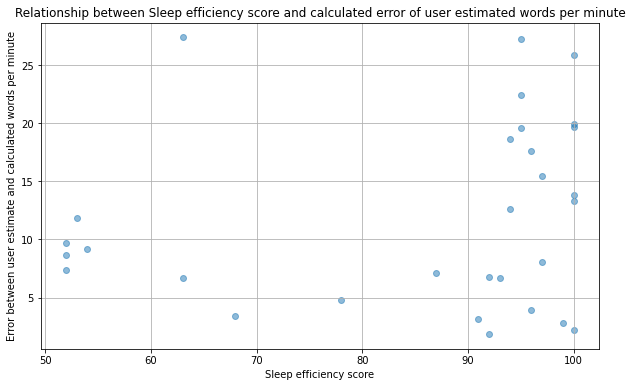

                                 OLS Regression Results                                 
Dep. Variable:     questionnaire_error_q3_value   R-squared:                       0.036
Model:                                      OLS   Adj. R-squared:                  0.002
Method:                           Least Squares   F-statistic:                     1.058
Date:                          Thu, 29 Aug 2024   Prob (F-statistic):              0.313
Time:                                  00:18:58   Log-Likelihood:                -103.12
No. Observations:                            30   AIC:                             210.2
Df Residuals:                                28   BIC:                             213.1
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

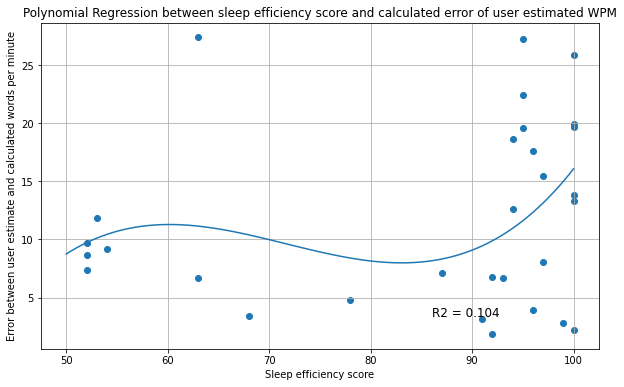

0.10442757244492806


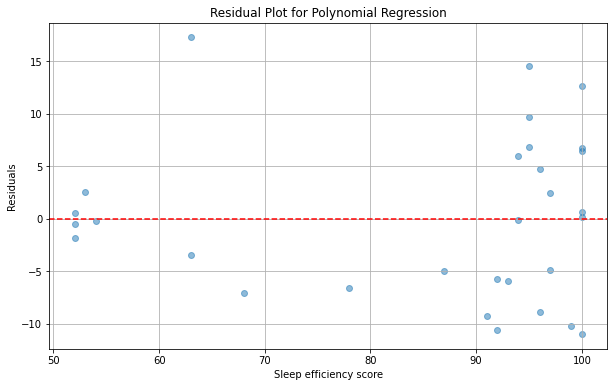

In [30]:
# Q3 vs sleep efficiency 


# Filter the DataFrame to exclude rows where sleep_efficiency or questionnaire_error_q3_value is 0
filtered_df = df[(df["prev_date_sleep_efficiency"] != 0) & (df["questionnaire_error_q3_value"] < 300) & (df["questionnaire_error_q3_value"] != None)
                 & (df["prev_date_sleep_efficiency"] != 0)]


plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_efficiency"], filtered_df["questionnaire_error_q3_value"], alpha=0.5)
plt.xlabel("Sleep efficiency score")
plt.ylabel("Error between user estimate and calculated words per minute")
plt.title("Relationship between Sleep efficiency score and calculated error of user estimated words per minute")
plt.grid(True)
plt.show()


mymodel = np.poly1d(np.polyfit(filtered_df["prev_date_sleep_efficiency"], filtered_df["questionnaire_error_q3_value"], 3))

myline = np.linspace(50, 100, 100)

# Polynomial Regression
X = filtered_df["prev_date_sleep_efficiency"]
y = filtered_df["questionnaire_error_q3_value"]

# Add a constant term (intercept) to the independent variable
X = sm.add_constant(X)

# Fit the polynomial regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model, including p-values
print(model.summary())

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_efficiency"], filtered_df["questionnaire_error_q3_value"])
plt.plot(myline, mymodel(myline))
plt.xlabel("Sleep efficiency score")
plt.ylabel("Error between user estimate and calculated words per minute")
plt.title("Polynomial Regression between sleep efficiency score and calculated error of user estimated WPM")
plt.grid(True)
r_squared = r2_score(filtered_df["questionnaire_error_q3_value"], mymodel(filtered_df["prev_date_sleep_efficiency"]))

# Annotate the plot with the R2 score
plt.annotate(f'R2 = {r_squared:.3f}', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

print(r_squared)

# Residual plot for Polynomial Regression
residuals = model.resid  # Get residuals directly from the fitted model

plt.figure(figsize=(10, 6))
plt.scatter(X["prev_date_sleep_efficiency"], residuals, alpha=0.5)  # Use column name for indexing
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Sleep efficiency score")
plt.ylabel("Residuals")
plt.title("Residual Plot for Polynomial Regression")
plt.grid(True)
plt.show()

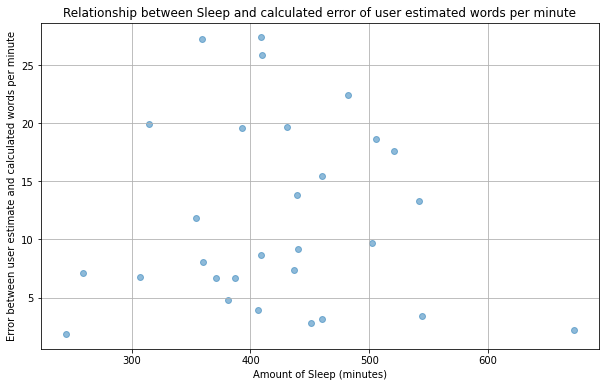

                                 OLS Regression Results                                 
Dep. Variable:     questionnaire_error_q3_value   R-squared:                       0.000
Model:                                      OLS   Adj. R-squared:                 -0.037
Method:                           Least Squares   F-statistic:                  0.006265
Date:                          Thu, 29 Aug 2024   Prob (F-statistic):              0.937
Time:                                  00:18:58   Log-Likelihood:                -100.71
No. Observations:                            29   AIC:                             205.4
Df Residuals:                                27   BIC:                             208.2
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

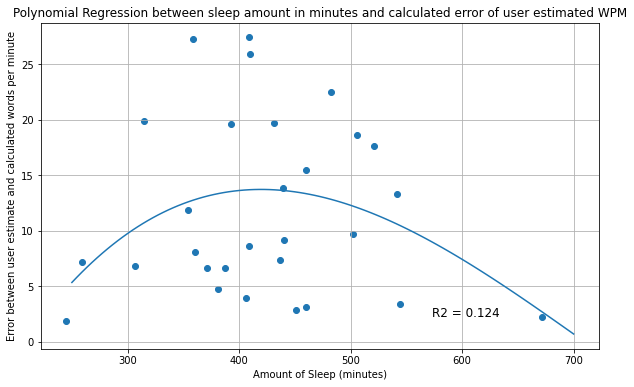

0.12363261369173872


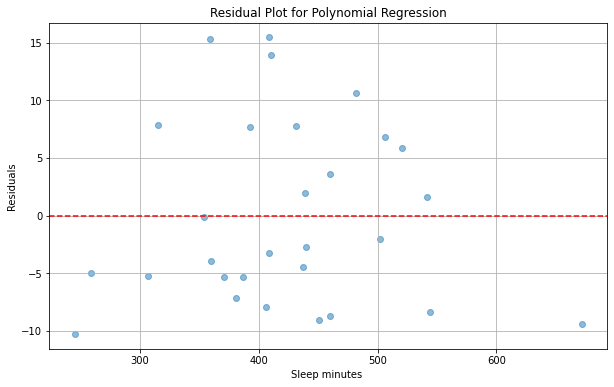

In [31]:
# Q3 vs sleep minutes 


# Filter the DataFrame to exclude rows where sleep_efficiency or questionnaire_error_q3_value is 0
filtered_df = df[(df["prev_date_sleep_minutes"] != 0) & (df["questionnaire_error_q3_value"] != 0) & (df["questionnaire_error_q3_value"] <= 300)
                & (df["prev_date_sleep_minutes"] < 1000) & (df["prev_date_sleep_minutes"] > 200)]


plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_minutes"], filtered_df["questionnaire_error_q3_value"], alpha=0.5)
plt.xlabel("Amount of Sleep (minutes)")
plt.ylabel("Error between user estimate and calculated words per minute")
plt.title("Relationship between Sleep and calculated error of user estimated words per minute")
plt.grid(True)
plt.show()

# Polynomial Regression
X = filtered_df["prev_date_sleep_minutes"]
y = filtered_df["questionnaire_error_q3_value"]

# Add a constant term (intercept) to the independent variable
X = sm.add_constant(X)

# Fit the polynomial regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model, including p-values
print(model.summary())

mymodel = np.poly1d(np.polyfit(filtered_df["prev_date_sleep_minutes"], filtered_df["questionnaire_error_q3_value"], 3))

myline = np.linspace(250, 700, 100)

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_minutes"], filtered_df["questionnaire_error_q3_value"])
plt.plot(myline, mymodel(myline))
plt.xlabel("Amount of Sleep (minutes)")
plt.ylabel("Error between user estimate and calculated words per minute")
plt.title("Polynomial Regression between sleep amount in minutes and calculated error of user estimated WPM")
plt.grid(True)
r_squared = r2_score(filtered_df["questionnaire_error_q3_value"], mymodel(filtered_df["prev_date_sleep_minutes"]))

# Annotate the plot with the R2 score
plt.annotate(f'R2 = {r_squared:.3f}', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

print(r2_score(filtered_df["questionnaire_error_q3_value"], mymodel(filtered_df["prev_date_sleep_minutes"])))

# Residual plot for Polynomial Regression
residuals = model.resid  # Get residuals directly from the fitted model

plt.figure(figsize=(10, 6))
plt.scatter(X["prev_date_sleep_minutes"], residuals, alpha=0.5)  # Use column name for indexing
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Sleep minutes ")
plt.ylabel("Residuals")
plt.title("Residual Plot for Polynomial Regression")
plt.grid(True)
plt.show()

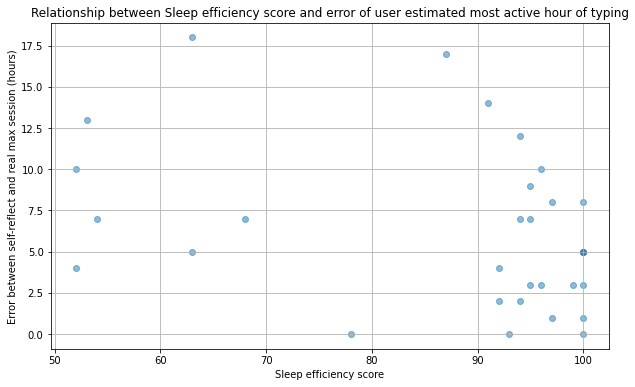

                                 OLS Regression Results                                 
Dep. Variable:     questionnaire_error_q4_value   R-squared:                       0.115
Model:                                      OLS   Adj. R-squared:                  0.085
Method:                           Least Squares   F-statistic:                     3.771
Date:                          Thu, 29 Aug 2024   Prob (F-statistic):             0.0619
Time:                                  00:18:58   Log-Likelihood:                -90.483
No. Observations:                            31   AIC:                             185.0
Df Residuals:                                29   BIC:                             187.8
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

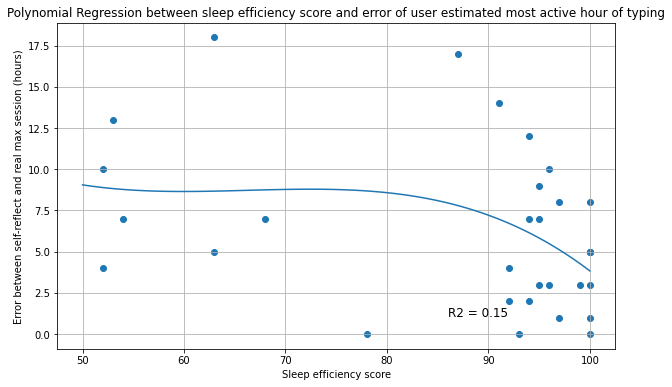

0.14707766048787463


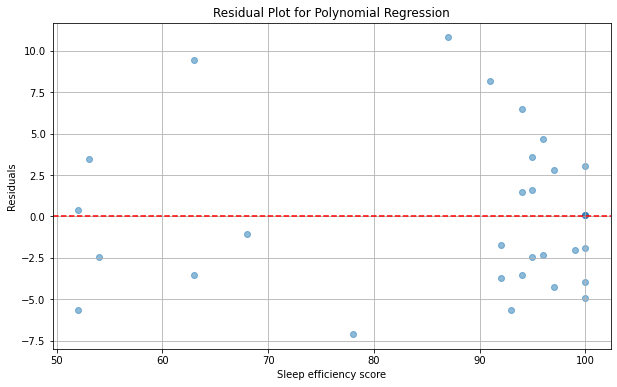

In [32]:
# Q4 error vs sleep efficiency 


# Filter the DataFrame to exclude rows where sleep_efficiency or questionnaire_error_q4_value is 0
filtered_df = df[(df["prev_date_sleep_efficiency"] != 0 )  & (df["questionnaire_error_q4_value"] != None)
                 & (df["prev_date_sleep_efficiency"] != None) & (df["questionnaire_error_q4_value"] < 20)]


plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_efficiency"], filtered_df["questionnaire_error_q4_value"], alpha=0.5)
plt.xlabel("Sleep efficiency score")
plt.ylabel("Error between self-reflect and real max session (hours)")
plt.title("Relationship between Sleep efficiency score and error of user estimated most active hour of typing")
plt.grid(True)
plt.show()


mymodel = np.poly1d(np.polyfit(filtered_df["prev_date_sleep_efficiency"], filtered_df["questionnaire_error_q4_value"], 3))

myline = np.linspace(50, 100, 100)

# Polynomial Regression
X = filtered_df["prev_date_sleep_efficiency"]
y = filtered_df["questionnaire_error_q4_value"]

# Add a constant term (intercept) to the independent variable
X = sm.add_constant(X)

# Fit the polynomial regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model, including p-values
print(model.summary())

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_efficiency"], filtered_df["questionnaire_error_q4_value"])
plt.plot(myline, mymodel(myline))
plt.xlabel("Sleep efficiency score")
plt.ylabel("Error between self-reflect and real max session (hours)")
plt.title("Polynomial Regression between sleep efficiency score and error of user estimated most active hour of typing")
plt.grid(True)
r_squared = r2_score(filtered_df["questionnaire_error_q4_value"], mymodel(filtered_df["prev_date_sleep_efficiency"]))

# Annotate the plot with the R2 score
plt.annotate(f'R2 = {r_squared:.2f}', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

print(r2_score(filtered_df["questionnaire_error_q4_value"], mymodel(filtered_df["prev_date_sleep_efficiency"])))

# Residual plot for Polynomial Regression
residuals = model.resid  # Get residuals directly from the fitted model

plt.figure(figsize=(10, 6))
plt.scatter(X["prev_date_sleep_efficiency"], residuals, alpha=0.5)  # Use column name for indexing
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Sleep efficiency score")
plt.ylabel("Residuals")
plt.title("Residual Plot for Polynomial Regression")
plt.grid(True)
plt.show()


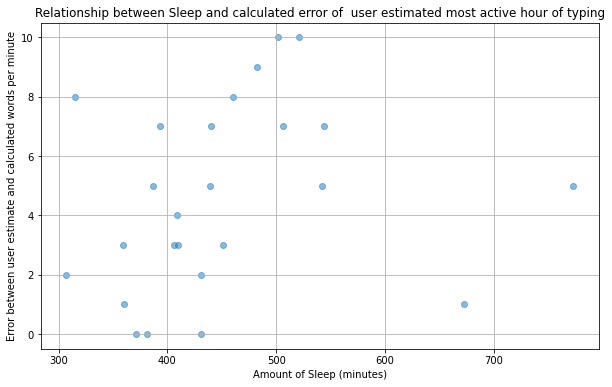

                                 OLS Regression Results                                 
Dep. Variable:     questionnaire_error_q4_value   R-squared:                       0.048
Model:                                      OLS   Adj. R-squared:                  0.007
Method:                           Least Squares   F-statistic:                     1.162
Date:                          Thu, 29 Aug 2024   Prob (F-statistic):              0.292
Time:                                  00:18:59   Log-Likelihood:                -63.025
No. Observations:                            25   AIC:                             130.0
Df Residuals:                                23   BIC:                             132.5
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

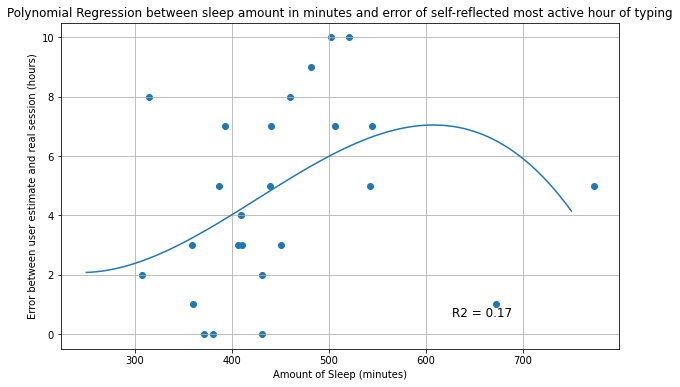

0.1680496323259314


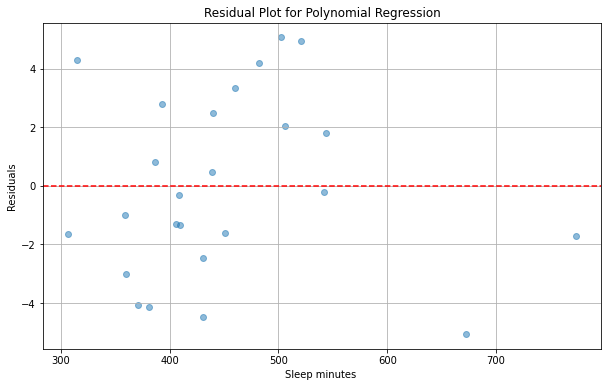

In [33]:
# Questionnaire error vs sleep minutes 


# Filter the DataFrame to exclude rows where sleep_efficiency or questionnaire_error_q3_value is 0
filtered_df = df[(df["prev_date_sleep_minutes"] != 0) & (df["questionnaire_error_q4_value"] < 12)
                & (df["prev_date_sleep_minutes"] < 800) & (df["prev_date_sleep_minutes"] > 250)]


plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_minutes"], filtered_df["questionnaire_error_q4_value"], alpha=0.5)
plt.xlabel("Amount of Sleep (minutes)")
plt.ylabel("Error between user estimate and calculated words per minute")
plt.title("Relationship between Sleep and calculated error of  user estimated most active hour of typing")
plt.grid(True)
plt.show()

# Polynomial Regression
X = filtered_df["prev_date_sleep_minutes"]
y = filtered_df["questionnaire_error_q4_value"]

# Add a constant term (intercept) to the independent variable
X = sm.add_constant(X)

# Fit the polynomial regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model, including p-values
print(model.summary())

mymodel = np.poly1d(np.polyfit(filtered_df["prev_date_sleep_minutes"], filtered_df["questionnaire_error_q4_value"], 3))

myline = np.linspace(250, 750, 100)

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["prev_date_sleep_minutes"], filtered_df["questionnaire_error_q4_value"])
plt.plot(myline, mymodel(myline))
plt.xlabel("Amount of Sleep (minutes)")
plt.ylabel("Error between user estimate and real session (hours)")
plt.title("Polynomial Regression between sleep amount in minutes and error of self-reflected most active hour of typing")
plt.grid(True)
r_squared = r2_score(filtered_df["questionnaire_error_q4_value"], mymodel(filtered_df["prev_date_sleep_minutes"]))

# Annotate the plot with the R2 score
plt.annotate(f'R2 = {r_squared:.2f}', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

print(r2_score(filtered_df["questionnaire_error_q4_value"], mymodel(filtered_df["prev_date_sleep_minutes"])))

# Residual plot for Polynomial Regression
residuals = model.resid  # Get residuals directly from the fitted model

plt.figure(figsize=(10, 6))
plt.scatter(X["prev_date_sleep_minutes"], residuals, alpha=0.5)  # Use column name for indexing
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Sleep minutes ")
plt.ylabel("Residuals")
plt.title("Residual Plot for Polynomial Regression")
plt.grid(True)
plt.show()

In [34]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

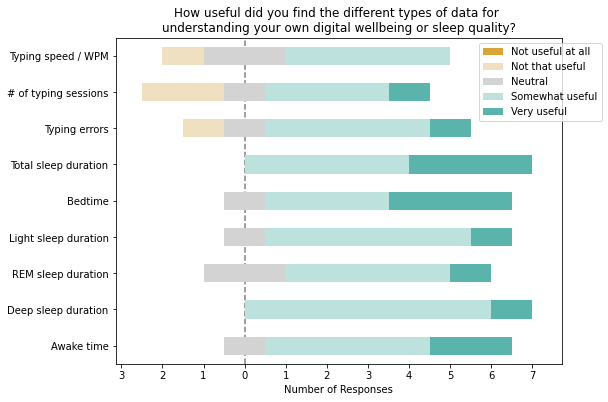

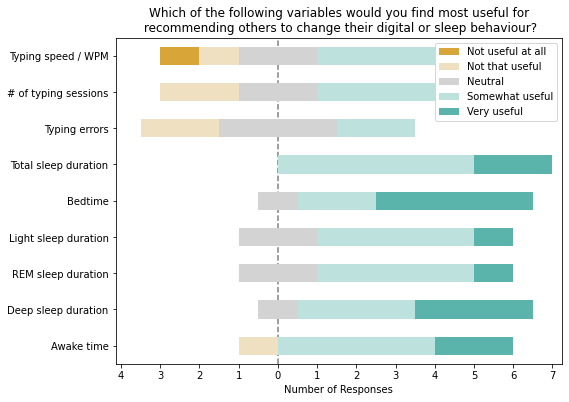

In [35]:
import plot_likert
from scipy.stats import kruskal


data = pd.read_csv('post_questionnaire.csv')
columns_to_keep = ["Typing speed / WPM", "# of typing sessions", "Typing errors", "Total sleep duration", "Bedtime", 
                   "Light sleep duration", "REM sleep duration", "Deep sleep duration", "Awake time"]
columns_to_keep2 = ["Typing speed / WPM2", "# of typing sessions2", "Typing errors2", "Total sleep duration2", "Bedtime2", 
                   "Light sleep duration2", "REM sleep duration2", "Deep sleep duration2", "Awake time2"]
filtered_data = data[columns_to_keep]

df = pd.DataFrame(filtered_data)
filtered_data2 = data[columns_to_keep2]

df2 = pd.DataFrame(filtered_data2)
#print(df)

# Define your Likert scale
likert_scale = ['Not useful at all', 'Not that useful', 'Neutral', 'Somewhat useful', 'Very useful']

y_labels = columns_to_keep.reverse()
# Set the scale for your data
fig = plot_likert.plot_likert(df, likert_scale, figsize=(8,6), colors=plot_likert.colors.likert5)
fig.set_title("How useful did you find the different types of data for \nunderstanding your own digital wellbeing or sleep quality?")
#fig.set_yticklabels(range(10),columns_to_keep)
#fig.yticks(range(10),columns_to_keep)
# Adjust legend position for the first plot
fig.legend(loc='upper right',bbox_to_anchor=(1.1, 1))
fig2 = plot_likert.plot_likert(df2, likert_scale, figsize=(8,6), colors=plot_likert.colors.likert5)
fig2.set_title("Which of the following variables would you find most useful for\n recommending others to change their digital or sleep behaviour?")
fig2.set_yticklabels(columns_to_keep)

# Adjust legend position for the second plot
fig2.legend(loc='upper right')




In [36]:
df = pd.read_csv('post_questionnaire.csv')

# Define columns for pre-study and post-study
columns_pre = ["Typing speed / WPM", "# of typing sessions", "Typing errors", "Total sleep duration", "Bedtime", 
               "Light sleep duration", "REM sleep duration", "Deep sleep duration", "Awake time"]
columns_post = ["Typing speed / WPM2", "# of typing sessions2", "Typing errors2", "Total sleep duration2", "Bedtime2", 
                "Light sleep duration2", "REM sleep duration2", "Deep sleep duration2", "Awake time2"]

value_mapping = {
    'Not useful at all': 1,
    'Not that useful': 2,
    'Neutral': 3,
    'Somewhat useful': 4,
    'Very useful': 5
}

df_likert = df.applymap(value_mapping.get)


results = {}
for pre_col, post_col in zip(columns_pre, columns_post):
    pre_values = df_likert[pre_col].values
    post_values = df_likert[post_col].values
    
    
    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(pre_values, post_values)
    results[pre_col] = (stat, p_value)

# Print results
for parameter, (stat, p_value) in results.items():
    print(f'Parameter: {parameter}, Statistic: {stat}, p-value: {p_value}')
    if p_value < 0.05:
        print('There is a statistically significant difference between pre-study and post-study values.')
    else:
        print('There is no statistically significant difference between pre-study and post-study values.')
        

        

Parameter: Typing speed / WPM, Statistic: 0.4786450662739318, p-value: 0.4890366877275172
There is no statistically significant difference between pre-study and post-study values.
Parameter: # of typing sessions, Statistic: 0.29275158339197305, p-value: 0.588462622679849
There is no statistically significant difference between pre-study and post-study values.
Parameter: Typing errors, Statistic: 2.2139338494018346, p-value: 0.13676951774656726
There is no statistically significant difference between pre-study and post-study values.
Parameter: Total sleep duration, Statistic: 0.28888888888888276, p-value: 0.5909334376847502
There is no statistically significant difference between pre-study and post-study values.
Parameter: Bedtime, Statistic: 0.17687074829931546, p-value: 0.6740763775004635
There is no statistically significant difference between pre-study and post-study values.
Parameter: Light sleep duration, Statistic: 0.2025974025973977, p-value: 0.6526324157182771
There is no stati

In [37]:
results_pre = {}
results_post = {}

# Perform Kruskal-Wallis test on pre-study columns
pre_values = [df_likert[col].values for col in columns_pre]
stat_pre, p_value_pre = kruskal(*pre_values)
results_pre['pre-study'] = (stat_pre, p_value_pre)

# Perform Kruskal-Wallis test on post-study columns
post_values = [df_likert[col].values for col in columns_post]
stat_post, p_value_post = kruskal(*post_values)
results_post['post-study'] = (stat_post, p_value_post)

# Print results
print('Pre-study comparison:')
print(f'Statistic: {stat_pre}, p-value: {p_value_pre}')
if p_value_pre < 0.05:
    print('There is a statistically significant difference among pre-study values.')
else:
    print('There is no statistically significant difference among pre-study values.')

print('\nPost-study comparison:')
print(f'Statistic: {stat_post}, p-value: {p_value_post}')
if p_value_post < 0.05:
    print('There is a statistically significant difference among post-study values.')
else:
    print('There is no statistically significant difference among post-study values.')

Pre-study comparison:
Statistic: 10.733069154832451, p-value: 0.21728734978951406
There is no statistically significant difference among pre-study values.

Post-study comparison:
Statistic: 20.593842459249295, p-value: 0.008308299020243578
There is a statistically significant difference among post-study values.


In [38]:
df = pd.read_csv('timewindow_data_filtered.csv')
# Pivot the DataFrame
#df = df[(df['prolific_id'] != '5e3c7f23a7f9e9078a2a009a')]

#df_filtered = df[(df['sleep_duration_minutes'] > 0)]

# Get the complete set of time window values
all_time_windows = range(1, 233)  # 233 because the range is exclusive on the upper end

# Create a DataFrame with the complete set of time window values
complete_time_df = pd.DataFrame({'time_window': all_time_windows})

# Merge the complete time window DataFrame with the original DataFrame
merged_df = pd.merge(complete_time_df, df, on='time_window', how='left')

# Pivot the merged DataFrame
pivot_df = merged_df.pivot(index='time_window', columns=['prolific_id', 'date'], values='session_count')

# Fill any missing values with 0
#pivot_df = pivot_df.fillna(0.0)
# Drop columns where all values are NaN
#pivot_df = pivot_df.dropna(axis=1, how='all')
pivot_df = pivot_df.fillna(0.0)


print("Flattened DataFrame")
pivot_df.to_csv('timewindow_data_flattened.csv')


Flattened DataFrame


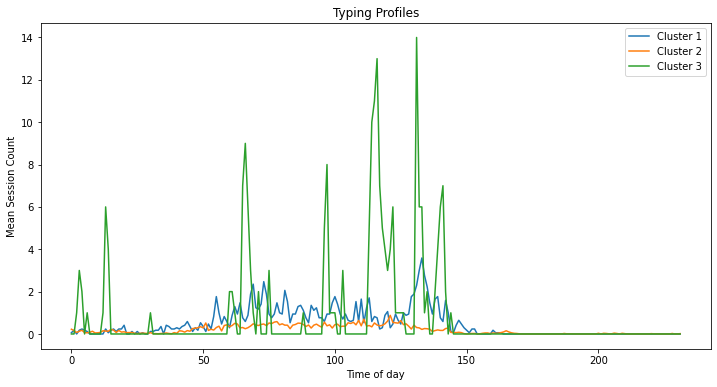

In [39]:

# Reshape the DataFrame to have days as rows and time windows as columns
sessions_per_day = pivot_df.T.values  # Transpose to have days as rows

# Apply K-means clustering
num_clusters = 3 # You can adjust this value based on your analysis

kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(sessions_per_day)

num_time_windows = 144  # 24 hours * 6 (10-minute intervals per hour)
time_windows = np.arange(1, num_time_windows + 1)
data = np.random.rand(num_time_windows)
# Add clusters to DataFrame

# Function to convert time window index to time of day
def time_window_to_time_label(time_window):
    minutes = (time_window - 145) * 10  # Adjust to make 144 as 00:00
    hours = (minutes // 60) % 24  # Ensure hours wrap around after 24
    minutes = minutes % 60
    return f'{hours:02}.{minutes:02}'

# Generate time labels
num_time_windows = 232
time_labels = [time_window_to_time_label(tw) for tw in range(1, num_time_windows + 1)]



# Visualize the clusters
plt.figure(figsize=(12, 6))
for i in range(num_clusters):
    cluster_sessions = sessions_per_day[clusters == i]
    plt.plot(cluster_sessions.mean(axis=0), label=f'Cluster {i+1}')
    # Set the time labels on the y-axis
    

plt.xlabel('Time of day')
plt.ylabel('Mean Session Count')
plt.title('Typing Profiles')
plt.legend()
plt.show()


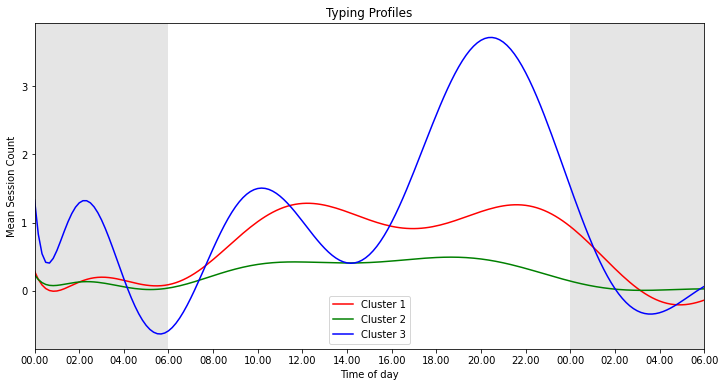

In [40]:
# Visualize the clusters with polynomial regression trend lines
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']

for i in range(num_clusters):
    cluster_sessions = sessions_per_day[clusters == i]
    mean_sessions = cluster_sessions.mean(axis=0)
    # Ensure mean_sessions has the same length as time_indices
    time_indices = np.arange(num_time_windows)
    if len(mean_sessions) != len(time_indices):
        mean_sessions = np.pad(mean_sessions, (0, len(time_indices) - len(mean_sessions)), 'constant')


    # Fit a polynomial to the mean sessions
    polynomial_order = 12 # Adjust as needed
    time_indices = np.arange(num_time_windows)
    poly_coeffs = np.polyfit(time_indices, mean_sessions, polynomial_order)
    poly_trend = np.polyval(poly_coeffs, time_indices)

    plt.plot(time_indices, poly_trend, label=f'Cluster {i+1}', color=colors[i])

# Highlight the primary active hours
plt.axvspan(0, 36, facecolor='grey', alpha=0.2)
plt.axvspan(144, 234, facecolor='grey', alpha=0.2)

# Set x-ticks to reflect the time of day
plt.xticks(ticks=np.arange(0, num_time_windows, 12), labels=[time_window_to_time_label(tw) for tw in np.arange(1, num_time_windows + 1, 12)])
# Set x-ticks to reflect the time of day

plt.xlim(0, 180)  # Show from 6:00 to 4:00
plt.xlabel('Time of day')
plt.ylabel('Mean Session Count')
plt.title('Typing Profiles')
plt.legend()
plt.show()

C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12120/3257007780.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_data['cluster'] += 1


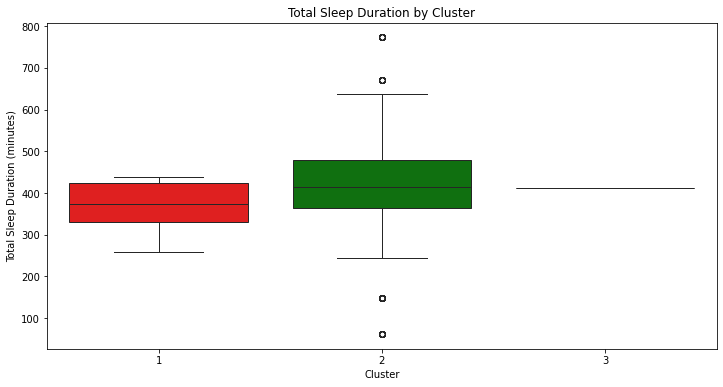

In [41]:
import seaborn as sns

# Get prolific_id and date from pivot_df columns
prolific_id_date = np.array(pivot_df.columns.tolist())

# Create a DataFrame for cluster assignments
clusters_df = pd.DataFrame(prolific_id_date, columns=['prolific_id', 'date'])
clusters_df['cluster'] = clusters

# Define custom color palette
custom_palette = {0: 'red', 1: 'green', 2: 'blue'}

# Merge the cluster information back to the original DataFrame
df_with_clusters = pd.merge(df, clusters_df, on=['prolific_id', 'date'], how='left')

# Extract sleep durations and clusters
sleep_data = df_with_clusters[['prolific_id', 'date','sleep_duration_minutes', 'cluster']]

# Filter sleep data for cluster 2
#cluster_2_sleep_data = sleep_data[sleep_data['cluster'] == 2]

# Print the sleep data for cluster 2
#print("Sleep data for Cluster 2:")
#print(cluster_2_sleep_data)

sleep_data.to_csv('tw_sleep_data.csv')

# Add 1 to cluster labels to make them start from 1 instead of 0
sleep_data['cluster'] += 1
# Define custom color palette
custom_palette = {1: 'red', 2: 'green', 3: 'blue'}

# Plot the candlestick (box) chart
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='sleep_duration_minutes', data=sleep_data, palette=custom_palette, hue='cluster', legend=False)
plt.xlabel('Cluster')
plt.ylabel('Total Sleep Duration (minutes)')
plt.title('Total Sleep Duration by Cluster')
plt.show()